**Project Objective**

Build a system that adjusts the market price of properties in Phoenix, AZ, based on climate/environmental risk (std_score) derived from a pre-trained Transformer model.

**Data Collection**

* Source: Realtor.com API (via RapidAPI)

* Query Parameters: ZIP code 85004, filter for properties listed "for sale"

Extracted Features:

* Address, price, beds, baths, lot size, coordinates, property type, listing URL

**Data Preparation**
  
* Parsed listings into a structured pandas DataFrame houses_df
* Cleaned for missing lat/lon coordinates to ensure all properties are geospatially usable

In [4]:
import requests
import time
import pandas as pd

# ✅ List of all Phoenix ZIP codes
PHOENIX_ZIPS = [
    "85003", "85004", "85006", "85007", "85008", "85009", "85012", "85013", "85014",
    "85015", "85016", "85017", "85018", "85020", "85021", "85022", "85023", "85024",
    "85027", "85028", "85029", "85031", "85032", "85033", "85034", "85035", "85037",
    "85040", "85041", "85042", "85043", "85044", "85045", "85048", "85050", "85051",
    "85053", "85054", "85083", "85085", "85086", "85087"
]

# ✅ Realtor API credentials
url = "https://realty-in-us.p.rapidapi.com/properties/v3/list"
headers = {
    "content-type": "application/json",
    "X-RapidAPI-Key": "33f7baa8aemshb3380eca00fc1c0p16a229jsn6f972fd9d47e",  # Replace with your actual key
    "X-RapidAPI-Host": "realty-in-us.p.rapidapi.com"
}

all_listings = []

# ✅ Loop through each ZIP code
for zip_code in PHOENIX_ZIPS:
    print(f"📦 Fetching ZIP {zip_code}...")

    payload = {
        "limit": 20,
        "offset": 0,
        "postal_code": zip_code,
        "status": ["for_sale"],
        "sort": {"direction": "desc", "field": "list_date"}
    }

    try:
        response = requests.post(url, json=payload, headers=headers)

        if response.status_code != 200:
            print(f"   ❌ Error {response.status_code}: {response.text[:80]}")
            continue

        data = response.json()
        listings = data.get("data", {}).get("home_search", {}).get("results", [])

        if not listings:
            print("   ❌ No listings found.")
            continue

        for i, home in enumerate(listings, 1):
            location = home.get('location', {}).get('address', {})
            coord = location.get('coordinate', {})

            relative_url = home.get('href', None)
            full_url = f"https://www.realtor.com{relative_url}" if relative_url else "N/A"

            record = {
                "address": location.get('line', 'N/A'),
                "city": location.get('city', 'N/A'),
                "zipcode": location.get('postal_code', 'N/A'),
                "price": home.get('list_price', 'N/A'),
                "beds": home.get('description', {}).get('beds', 'N/A'),
                "baths": home.get('description', {}).get('baths', 'N/A'),
                "lot_sqft": home.get('description', {}).get('lot_sqft', 'N/A'),
                "type": home.get('description', {}).get('type', 'N/A'),
                "lat": coord.get('lat', 'N/A'),
                "lon": coord.get('lon', 'N/A'),
                "url": full_url
            }

            all_listings.append(record)

            print(f"   {i}. {record['address']}, {record['city']} {record['zipcode']} – ${record['price']:,}")

        # ⏱ Prevent hitting rate limits
        time.sleep(1.5)

    except Exception as e:
        print(f"   ❌ Failed on ZIP {zip_code}: {e}")

# ✅ Final: Convert to DataFrame
df = pd.DataFrame(all_listings)
print(f"\n✅ Total listings collected: {len(df)}")

📦 Fetching ZIP 85003...
   1. 235 W Portland St, Phoenix 85003 – $825,000
   2. 805 N 4th Ave Unit 701, Phoenix 85003 – $240,000
   3. 620 N 4th Ave Apt 10, Phoenix 85003 – $499,500
   4. 822 S 4th Ave, Phoenix 85003 – $975,000
   5. 346 W Edgemont Ave, Phoenix 85003 – $899,000
   6. 114 W Adams St Unit 202, Phoenix 85003 – $349,990
   7. 805 N 4th Ave Unit 508, Phoenix 85003 – $240,000
   8. 522 W Cambridge Ave, Phoenix 85003 – $849,900
   9. 17 W Vernon Ave Unit 508, Phoenix 85003 – $769,000
   10. 530 W Willetta St, Phoenix 85003 – $949,000
   11. 114 W Adams St Unit 505, Phoenix 85003 – $314,000
   12. 69 W Virginia Ave, Phoenix 85003 – $750,000
   13. 530 W Almeria Rd, Phoenix 85003 – $799,900
   14. 16 W Encanto Blvd Unit 26, Phoenix 85003 – $405,000
   15. 200 W Portland St Unit 1024, Phoenix 85003 – $895,000
   16. 16 W Encanto Blvd Unit 110, Phoenix 85003 – $459,900
   17. 546 W Cambridge Ave, Phoenix 85003 – $850,000
   18. 17 W Vernon Ave Unit 31, Phoenix 85003 – $449,000
  

**Risk Score Integration**

* Imported external climate risk scores (std_score) per (lat, lon) from phoenix_scores.csv
* Used a spatial nearest-neighbor search (via scipy.cKDTree) to match each house to the closest risk grid point
* Merged matched std_score into each row of houses_df

In [6]:
risk_df = pd.read_csv("Dataset/phoenix_scores.csv")

In [7]:
from scipy.spatial import cKDTree

# Prepare coordinates
risk_coords = risk_df[["lat", "lon"]].drop_duplicates().values
tree = cKDTree(risk_coords)

# Find nearest risk coordinate for each house
_, idxs = tree.query(df[["lat", "lon"]].values)
nearest_risk_coords = risk_coords[idxs]

# Merge coordinates into house dataframe
df["nearest_lat"] = nearest_risk_coords[:, 0]
df["nearest_lon"] = nearest_risk_coords[:, 1]


In [8]:
df = df.merge(
    risk_df.rename(columns={'lat': 'nearest_lat', 'lon': 'nearest_lon'}),
    on=['nearest_lat', 'nearest_lon'],
    how='left'
)

In [9]:
df

,address,city,zipcode,price,beds,baths,lot_sqft,type,lat,lon,url,nearest_lat,nearest_lon,Unnamed: 0,std_score
0,235 W Portland St,Phoenix,85003,825000,2.0,4.0,1510.0,townhomes,33.459540,-112.077572,https://www.realtor.comhttps://www.realtor.com...,33.441667,-112.058333,46,0.306647
1,805 N 4th Ave Unit 701,Phoenix,85003,240000,1.0,1.0,720.0,condos,33.457092,-112.078709,https://www.realtor.comhttps://www.realtor.com...,33.441667,-112.058333,46,0.306647
2,620 N 4th Ave Apt 10,Phoenix,85003,499500,2.0,2.0,620.0,townhomes,33.455455,-112.079297,https://www.realtor.comhttps://www.realtor.com...,33.441667,-112.100000,45,0.155872
3,822 S 4th Ave,Phoenix,85003,975000,NaN,NaN,6450.0,multi_family,33.439244,-112.079729,https://www.realtor.comhttps://www.realtor.com...,33.441667,-112.100000,45,0.155872
4,346 W Edgemont Ave,Phoenix,85003,899000,3.0,2.0,7810.0,single_family,33.479656,-112.080215,https://www.realtor.comhttps://www.realtor.com...,33.483333,-112.100000,55,0.238272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,4230 W Palace Station Rd,New River,85087,529900,4.0,2.0,6304.0,single_family,33.886409,-112.151235,https://www.realtor.comhttps://www.realtor.com...,33.900000,-112.141667,154,0.371170
826,4427 W Powell Dr,New River,85087,525000,5.0,3.0,4950.0,single_family,33.872293,-112.155192,https://www.realtor.comhttps://www.realtor.com...,33.858333,-112.141667,144,0.300705
827,44015 N 20th St,New River,85087,725000,3.0,2.0,52272.0,single_family,33.884869,-112.038210,https://www.realtor.comhttps://www.realtor.com...,33.900000,-112.058333,156,0.141058
828,42805 N 8th St,New River,85087,99000,NaN,0.0,44431.0,land,33.885010,-112.086301,https://www.realtor.comhttps://www.realtor.com...,33.900000,-112.100000,155,0.289457


**Risk-Adjusted Price Computation (CAPI)**

Used a custom formula to compute a "climate-adjusted price index" (CAPI):
* If the std_score ≤ 0.2 → apply a positive uplift (discounted risk)
* If std_score > 0.2 → apply a penalty using a quadratic function

Constants:
* ALPHA = 0.5 → reward for low risk
* BETA = 0.4 → penalty for high risk
* THRESHOLD = 0.2 → baseline risk threshold

New columns created:
* capi_price: adjusted price
* adjustment_%: percent difference from original listing

In [16]:
import pandas as pd

# Parameters based on the report
ALPHA = 0.5   # Premium coefficient for CRS ≤ 0.2
BETA = 0.4    # Penalty coefficient for CRS > 0.2
THRESHOLD = 0.2  # CRS threshold

# Define calculation logic
def calculate_capi(row, alpha=ALPHA, beta=BETA, threshold=THRESHOLD):
    crs = row['std_score']
    market_price = row['price']
    
    if crs <= threshold:
        uplift = alpha * (threshold - crs)
        capi_price = market_price * (1 + uplift)
    else:
        penalty = beta * (crs - threshold) ** 2
        capi_price = market_price * (1 - penalty)
    
    return capi_price

# Apply the calculation
df['capi_price'] = df.apply(calculate_capi, axis=1)
df['adjustment_%'] = ((df['capi_price'] - df['price']) / df['price'] * 100).round(2)
df['capi_price'] = df['capi_price'].apply(lambda x: f"{x:.2f}")

# Display the result
df[['address', 'price', 'std_score', 'capi_price', 'adjustment_%']]

,address,price,std_score,capi_price,adjustment_%
0,235 W Portland St,825000,0.306647,821246.70,-0.45
1,805 N 4th Ave Unit 701,240000,0.306647,238908.13,-0.45
2,620 N 4th Ave Apt 10,499500,0.155872,510521.00,2.21
3,822 S 4th Ave,975000,0.155872,996512.46,2.21
4,346 W Edgemont Ave,899000,0.238272,898473.28,-0.06
...,...,...,...,...,...
825,4230 W Palace Station Rd,529900,0.371170,523689.72,-1.17
826,4427 W Powell Dr,525000,0.300705,522870.29,-0.41
827,44015 N 20th St,725000,0.141058,746366.63,2.95
828,42805 N 8th St,99000,0.289457,98683.10,-0.32


**Insights**

The following charts and summaries aim to:
* Highlight how price adjustments vary across the housing stock
* Identify properties most rewarded or penalized by the model
* Examine the relationship between risk and price
* Quantify the overall financial impact of risk integration across listings

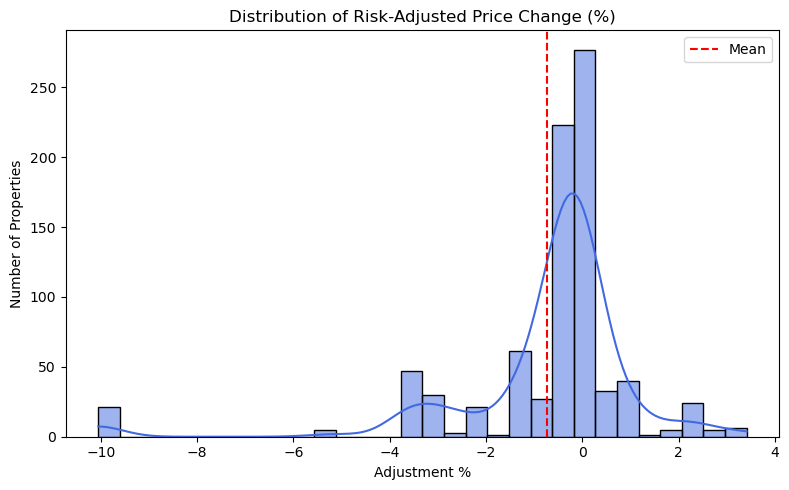

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df['adjustment_%'].dropna(), bins=30, kde=True, color='royalblue')
plt.title("Distribution of Risk-Adjusted Price Change (%)")
plt.xlabel("Adjustment %")
plt.ylabel("Number of Properties")
plt.axvline(df['adjustment_%'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.tight_layout()
plt.show()

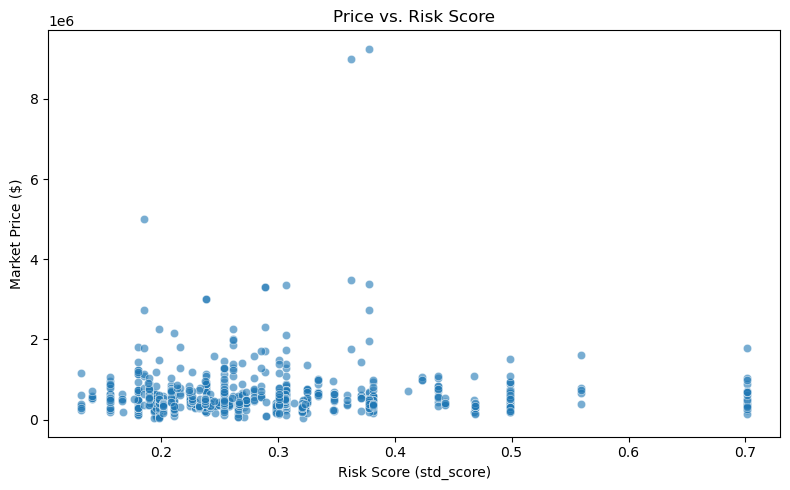

In [21]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='std_score', y='price', alpha=0.6)
plt.title("Price vs. Risk Score")
plt.xlabel("Risk Score (std_score)")
plt.ylabel("Market Price ($)")
plt.tight_layout()
plt.show()

In [ ]:
top_positive = df.sort_values('adjustment_%', ascending=False).head(10)
top_negative = df.sort_values('adjustment_%').head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='adjustment_%', y='address', data=top_positive, palette='Greens_r')
plt.title("Top 10 Most Rewarded Properties")
plt.xlabel("Adjustment %")
plt.ylabel("Address")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='adjustment_%', y='address', data=top_negative, palette='Reds')
plt.title("Top 10 Most Penalized Properties")
plt.xlabel("Adjustment %")
plt.ylabel("Address")
plt.tight_layout()
plt.show()

In [ ]:
metrics = {
    "Total Listings": len(df),
    "Mean Adjustment %": df['adjustment_%'].mean(),
    "Median Adjustment %": df['adjustment_%'].median(),
    "Max Adjustment %": df['adjustment_%'].max(),
    "Min Adjustment %": df['adjustment_%'].min(),
    "Total Market Value": df['price'].sum(),
    "Total Adjusted Value": df['capi_price'].sum()
}
pd.DataFrame(metrics, index=["Metric"]).T